In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) 
from sidm.tools import ffschema, sidm_processor, utilities, scaleout
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
import mplhep as hep

# Load style sheet
# plt.style.use(hep.style.CMS)  # or ATLAS/LHCb2

# h, bins = np.histogram(np.random.random(1000))
# fig, ax = plt.subplots()
# hep.histplot(h, bins)

utilities.set_plot_style()

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

/home/cms-jovyan/SIDM/sidm/test_notebooks/../../sidm/tools/scaleout.py:12: UserWarning: Registering a `SchedulerPlugin` as a worker plugin is not allowed, registering as a scheduler plugin instead. To register as a worker plugin, inherit from `WorkerPlugin`.
  client.register_worker_plugin(PipInstall(packages=dependencies, pip_options=["--upgrade"]))


Connection method: Direct,
Dashboard: /user/yfv2ev@virginia.edu/proxy/8787/status,
Comm: tls://192.168.202.51:8786,Workers: 0
Dashboard: /user/yfv2ev@virginia.edu/proxy/8787/status,Total threads: 0
Started: 5 hours ago,Total memory: 0 B


In [3]:
SIDM_samples = [
    #"2Mu2E_100GeV_1p2GeV_9p6mm", 
    #"4Mu_100GeV_1p2GeV_9p6mm",
    
    #"2Mu2E_1000GeV_0p25GeV_0p02mm",
    #"4Mu_1000GeV_0p25GeV_0p02mm"
]

samples = [
    "DYJetsToLL_M10to50", # Background
    "DYJetsToLL_M50",
    
    "QCD_Pt15to20", #Works
    "QCD_Pt20to30", #issue, needs many files to fill all histograms
    "QCD_Pt30to50", #Broken, throws KeyError: 'akjet_ak4PFJetsCHS_jetid' --- Fixed by change in ffschema
    #"QCD_Pt50to80", #Works
    #"QCD_Pt80to120", #Works
    #"QCD_Pt120to170", # Really broken, Exception: Failed processing file: WorkItem(dataset='QCD_Pt120to170' ...)
    #"QCD_Pt170to300", #Works
    #"QCD_Pt300to470", #Works
    #"QCD_Pt470to600", #Works
    #"QCD_Pt600to800", #Works
    #"QCD_Pt800to1000", #Works
    #"QCD_Pt1000toInf", #Works
    
    "TTJets",
    "WW",
    "WZ",
    "ZZ",
]

for sample in SIDM_samples:
    samples.append(sample)

fileset = utilities.make_fileset(samples, "ffntuple_v2") #max_files argument was removed, so it defaults to use all the files in each sample
#fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=1) #CHANGED: background appears to use v2 ntuples instead of v4

#print(fileset)

The error in QCD_Pt30to50, as well as the error in making the histogram "lj_pfiso", is based on a missing attribute in ffschema. The issue was fixed by adding a condition that the attribute could only be retrieved from branch_forms if it exists in branch_forms initially (ffschema.py line 191). The error in QCD_Pt120to170, and intermittently in other filesets is caused by samples without lepton jets in them. When a file has no lepton jets, the key "ntuple_ljs" returns a keyError. This is caused by the lack of "evts.pfjets" in the ntuples and cannot be corrected. A possible fix may be adding a condition to only process events if this category is not empty, but it is not resolved yet.

There is also an error in dask. I'm not sure of the source, but it cannot run any files (except the first two SIDM samples and all dibosons listed) as far as I know, giving a runtime error based on 

"RuntimeError: Expected LorentzVector L1TOHLT_DoubleL2Mu25NoVtx_2Cha to end with 'p4' or 'rawP4'."
The cited LorentzVector is different depending on file. I have seen the following ones appear in the errors:

L1TOHLT_DoubleL2Mu25NoVtx_2Cha (for various samples)

L1TOHLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed (for various samples)

TOHLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4 (for QCD, but QCD has also had the cosmicSeed vector)

NOTE: This results in the message "Expected LorentzVector TOHLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4 to end with 'p4' or 'rawP4'," even though the vector does end in 'p4'

In [4]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.DaskExecutor(client=client),
    #executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
            "baseNoLj"
           ] # NOTE: the channel used determines the cuts applied. baseNoLj removes the checks for multiple jets.

hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
collection = utilities.flatten(hist_menu["base"]) #To change the histograms used, swap "base" for the other collections
print(collection)

p = sidm_processor.SidmProcessor(
    channels, ["base"]) # not sure if base_plus_gen applies to the background

# test if processor is serializable
import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))


output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

['pv_n', 'pv_ndof', 'pv_z', 'pv_rho', 'electron_n', 'electron_pt', 'electron_eta_phi', 'photon_n', 'photon_pt', 'photon_eta_phi', 'muon_n', 'muon_pt', 'muon_eta_phi', 'muon_absD0', 'muon_absD0_lowRange', 'dsaMuon_n', 'dsaMuon_pt', 'dsaMuon_eta_phi', 'dsaMuon_absD0', 'dsaMuon_absD0_lowRange', 'lj_n', 'egmlj_n', 'lj_pt', 'egm_lj_pt', 'mu_lj_pt', 'lj0_pt', 'lj1_pt', 'lj0_e', 'lj1_e', 'lj0_dRSpread', 'lj1_dRSpread', 'lj_eta_phi', 'lj_electronN', 'lj_photonN', 'lj_electronPhotonN', 'lj_muonN', 'ljsource_n', 'ljsource_pt', 'ljsource_eta_phi', 'ljsource_charge', 'ljsource_type', 'electron_lj_dR', 'electron_lj_dR_lowRange', 'photon_lj_dR', 'photon_lj_dR_lowRange', 'photon_lj_dR_reallyLowRange', 'muon_lj_dR', 'muon_lj_dR_lowRange', 'dsaMuon_lj_dR', 'dsaMuon_lj_dR_lowRange', 'lj_lj_absdphi', 'lj_lj_invmass', 'lj_lj_invmass_lowRange', 'lj_pfIsolation05', 'lj0_pfIsolation05', 'lj1_pfIsolation05', 'lj_pfIsolationPtNoPU05', 'lj_pfIsolationPt05', 'lj_pfIsolation07', 'lj_pfIsolationPtNoPU07', 'lj_pfIs

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


Text(0.5, 1.0, 'lj_pt')

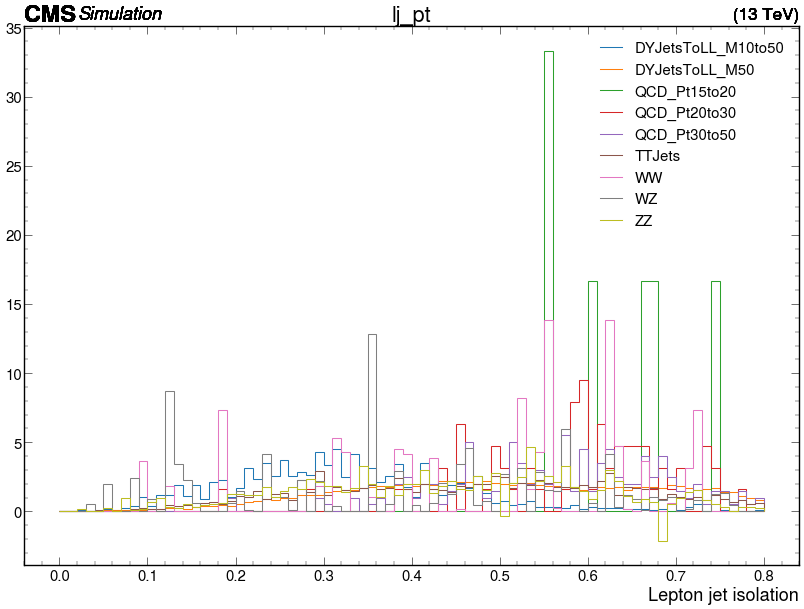

In [5]:
plt.subplots(1, 1, figsize=(20,14))
for i in range(len(samples)):
    utilities.plot(out[samples[i]]["hists"]["lj_pfIsolation07"]["baseNoLj", :1200j], yerr=False, density=True, flow='none')
plt.legend(samples)
plt.title("lj_pt")

In [9]:
# Post-processing, combines background samples into larger sets.
# This applies to cutflows and to histograms
hist_set = hist_choice
hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
collection = utilities.flatten(hist_menu[hist_set]) #To change the histograms used, swap "base" for the other collections

sample_list = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]

for sample in samples:
    if not(sample[0] == 'D') and not(sample[0] == 'Q') and not((sample[0] == 'W' or sample[0] == 'Z')) and not(sample[0] == 'T'):
        sample_list.append(sample)

#Combine Drell-Yan
keys = list(output['out']["DYJetsToLL_M10to50"]["cutflow"].keys())[:]
DY_Cutflow = {k: output['out']["DYJetsToLL_M10to50"]["cutflow"][k] for k in keys}
    
keys = list(output['out']["DYJetsToLL_M10to50"]["hists"].keys())[:]
DY_Hists = {k: output['out']["DYJetsToLL_M10to50"]["hists"][k] for k in keys}
    
keys = list(output['out']["DYJetsToLL_M50"]["cutflow"].keys())[:]
temp = {k: output['out']["DYJetsToLL_M50"]["cutflow"][k] for k in keys}
for channel in channels:
    DY_Cutflow[channel] = DY_Cutflow[channel] + temp[channel]
keys = list(output['out']["DYJetsToLL_M50"]["hists"].keys())[:]
temp = {k: output['out']["DYJetsToLL_M50"]["hists"][k] for k in keys}    
for hist_name in collection:
    DY_Hists[hist_name] = DY_Hists[hist_name] + temp[hist_name]

#Combine QCD
keys = list(output['out']["QCD_Pt15to20"]["cutflow"].keys())[:]
QCD_Cutflow = {k: output['out']["QCD_Pt15to20"]["cutflow"][k] for k in keys}
keys = list(output['out']["QCD_Pt15to20"]["hists"].keys())[:]
QCD_Hists = {k: output['out']["QCD_Pt15to20"]["hists"][k] for k in keys}
    
for sample in samples:
    if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
        keys = list(output['out'][sample]["cutflow"].keys())[:]
        temp = {k: output['out'][sample]["cutflow"][k] for k in keys}
        for channel in channels:
            QCD_Cutflow[channel] = QCD_Cutflow[channel] + temp[channel]
                
        keys = list(output['out'][sample]["hists"].keys())[:]
        temp = {k: output['out'][sample]["hists"][k] for k in keys}
        for hist_name in collection:
            QCD_Hists[hist_name] = QCD_Hists[hist_name] + temp[hist_name]

#Combine diboson
keys = list(output['out']["WW"]["hists"].keys())[:]
DiBoson_Hists = {k: output['out']["WW"]["hists"][k] for k in keys}

keys = list(output['out']["WW"]["cutflow"].keys())[:]
DiBoson_Cutflow = {k: output['out']["WW"]["cutflow"][k] for k in keys}

for sample in ["WZ", "ZZ"]:
    keys = list(output['out']["WZ"]["cutflow"].keys())[:]
    temp = {k: output['out']["WZ"]["cutflow"][k] for k in keys}
    for channel in channels:
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + temp[channel]

    keys = list(output['out'][sample]["hists"].keys())[:]
    temp = {k: output['out'][sample]["hists"][k] for k in keys}
    for hist_name in collection:
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + temp[hist_name]

#Add ttbar
keys = list(output['out']["TTJets"]["hists"].keys())[:]
TT_Hists = {k: output['out']["TTJets"]["hists"][k] for k in keys}

keys = list(output['out']["TTJets"]["cutflow"].keys())[:]
TT_Cutflow = {k: output['out']["TTJets"]["cutflow"][k] for k in keys}

#Combine total background
keys = list(output['out']["DYJetsToLL_M10to50"]["hists"].keys())[:]
bg_Hists = {k: output['out']["DYJetsToLL_M10to50"]["hists"][k] for k in keys}

keys = list(output['out']["DYJetsToLL_M10to50"]["cutflow"].keys())[:]
bg_Cutflow = {k: output['out']["DYJetsToLL_M10to50"]["cutflow"][k] for k in keys}

for sample in samples:
    if ((sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') or (sample[0] == 'T')) and (sample != "DYJetsToLL_M10to50"):
        keys = list(output['out'][sample]["cutflow"].keys())[:]
        temp = {k: output['out'][sample]["cutflow"][k] for k in keys}
        for channel in channels:
            bg_Cutflow[channel] = bg_Cutflow[channel] + temp[channel]

        keys = list(output['out'][sample]["hists"].keys())[:]
        temp = {k: output['out'][sample]["hists"][k] for k in keys}
        for hist_name in collection:
            bg_Hists[hist_name] = bg_Hists[hist_name] + temp[hist_name]

In [7]:
print(samples)

['DYJetsToLL_M10to50', 'DYJetsToLL_M50', 'QCD_Pt15to20', 'QCD_Pt20to30', 'QCD_Pt30to50', 'TTJets', 'WW', 'WZ', 'ZZ']


In [8]:
bg_Cutflow["baseNoLj"].print_table(fraction=False)

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection             51853.4      51853.4
PV filter                51853.4      51853.4
Cosmic veto              51847.4      51847.4


/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/p

Text(0.5, 1.0, 'lj_pfiso')

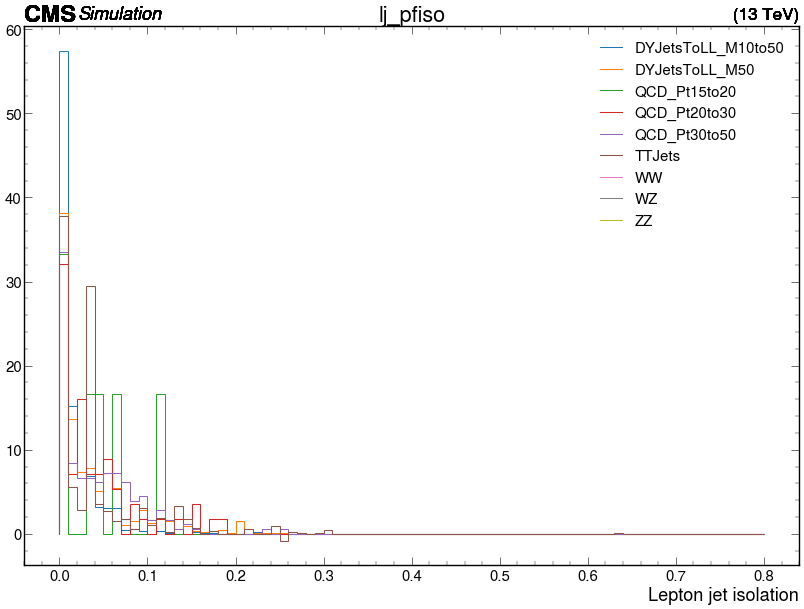

In [17]:
plt.subplots(1, 1, figsize=(20,14))
for sample in samples:
    utilities.plot(out[sample]["hists"]["lj_pfiso"]["baseNoLj", :1200j], yerr=False, density=True, flow='none')
plt.legend(samples)
plt.title("lj_pfiso")